# <center> <span style="font-family: Virgil GS, sans-serif; color:#97f788">AUC/Gini and PR-AUC</span> </center>

<span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

Synthetic example

In [1]:
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Arial"

In [2]:
import numpy as np


def generate_synthetic_data(desired_auc, event_rate, n_total=100):
    # Calculate t
    t = np.sqrt(np.log(1 / (1 - desired_auc) ** 2))

    # Calculate z
    z = t - (
        (2.515517 + 0.802853 * t + 0.0103328 * t**2)
        / (1 + 1.432788 * t + 0.189269 * t**2 + 0.001308 * t**3)
    )

    # Calculate d
    d = z * np.sqrt(2)

    # Calculate the size of each class based on the event rate
    n_event = int(n_total * event_rate)
    n_non_event = n_total - n_event

    st_dev = 0.30
    # Generate random numbers for the event and non-event classes
    x_event = np.random.normal(d, st_dev, n_event)
    x_non_event = np.random.normal(0, st_dev, n_non_event)

    # Concatenate the event and non-event classes
    x = np.concatenate((x_non_event, x_event))
    y = np.concatenate((np.zeros(n_non_event), np.ones(n_event)))
    y_true = np.concatenate((np.zeros(n_non_event), np.ones(n_event)))

    # Desired properties of the logit score
    desired_mean = -2.0000
    desired_std = 0.399522
    desired_min = -2.935578
    desired_max = -1.173120

    # Adjust the generated data to match the desired quartiles and max
    x = (x - np.mean(x)) * (desired_std / np.std(x)) + desired_mean
    x_min = np.min(x)
    x_range = np.max(x) - x_min
    x = (x - x_min) * (desired_max - desired_min) / x_range + desired_min

    y_scores = 1 / (1 + np.exp(-x))

    return y_true, y_scores

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


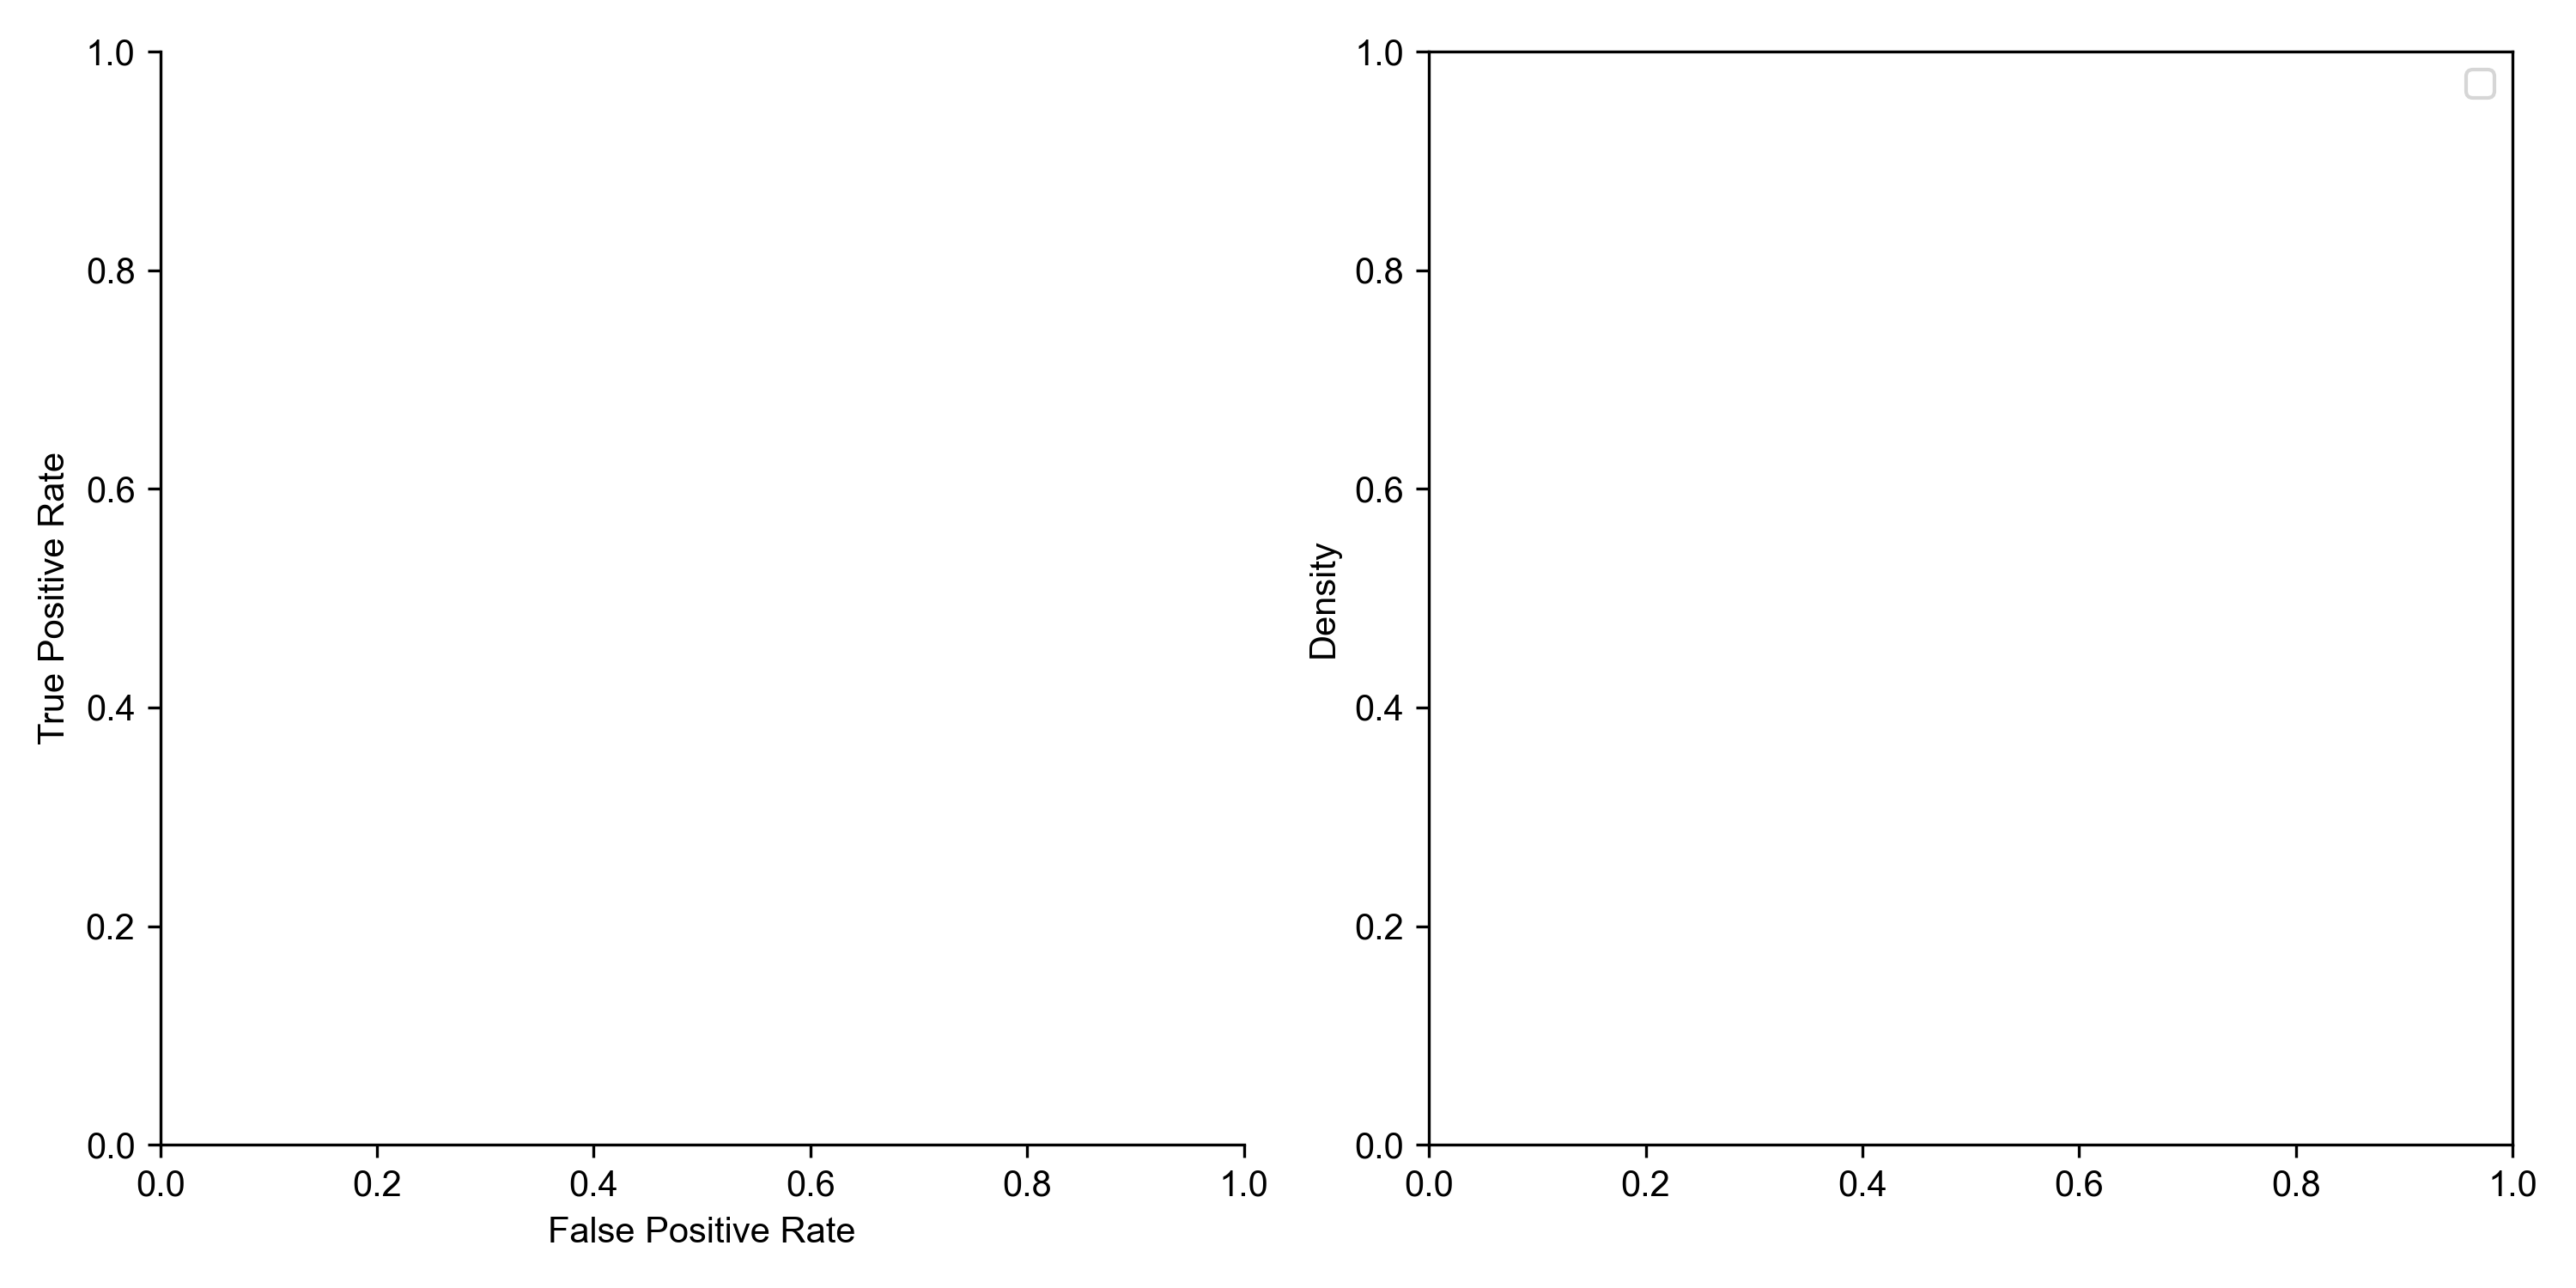

In [54]:
%matplotlib widget
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import auc, roc_curve
import pandas as pd
from scipy.special import logit

# Create figure and subplots
fig, (ax_roc, ax_kde) = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
ax_roc.axis([0, 1, 0, 1])
for ax in [ax_roc]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")

# Initialize the ROC AUC plot and label
(roc_plot,) = ax_roc.plot([], [], lw=2, color="#52a1ec", label="ROC AUC Curve")

# Initialize the KDE plot and label
kde_plot = sns.kdeplot([], label="KDE", color="red", ax=ax_kde)
ax_kde.set_ylabel("Density")
ax_kde.legend()

# Define the AUC values you want to visualize
desired_aucs = np.arange(0.5, 0.99, 0.01)
n_total = 10_000
eps = 1.0

# Common parameters for KDE plots
kde_common_params = {
    "edgecolor": None,
    "common_grid": True,
    "common_norm": True,
    "levels": 10,
    "fill": True,
    "bw_method": 2.5, # 2.0
    "bw_adjust": 0.5,
    # "gridsize": 1000
}


# Function to update ROC curve and KDE plot
def update_auc(i):
    auc_value = desired_aucs[i]
    rate_value = 0.5  # Fixed imbalance at 50%
    y_true, y_scores = generate_synthetic_data(
        auc_value, event_rate=rate_value, n_total=n_total
    )

    # Update ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    roc_plot.set_data(fpr, tpr)
    roc_plot.set_label(f"AUC = {roc_auc:.2%}")
    ax_roc.set_title("ROC Curve")
    ax_roc.plot([0, 1], [0, 1], color="gray", linestyle="--", linewidth=0.5)
    ax_roc.legend(loc='lower right')  # Add legend for ROC plot

    ax_kde.clear()
    ax_kde.set_title("Class Separation")
    
    # Update KDE plot for Class 1
    sns.kdeplot(
        logit(pd.Series(y_scores[y_true == 1])),
        label="Class 1",
        color="red",
        ax=ax_kde,
        **kde_common_params,
    )
    
    # Update KDE plot for Class 0
    sns.kdeplot(
        logit(pd.Series(y_scores[y_true == 0])),
        label="Class 0",
        color="#52a1ec",
        ax=ax_kde,
        **kde_common_params,
    )
    ax_kde.set_xlabel("Prediction (logit score)")
    
    # Remove top and right border
    ax_kde.spines['top'].set_visible(False)
    ax_kde.spines['right'].set_visible(False)

    # Set x-axis limits based on observed scores
    min_score = logit(min(y_scores))
    max_score = logit(max(y_scores))
    ax_kde.set_xlim(min_score - eps, max_score + eps)
    
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.legend()

    # Set super title above the subplots with increased padding
    plt.subplots_adjust(top=0.85)
    fig.suptitle("Area under the ROC Curve", fontsize=16, y=0.99)

    return roc_plot, kde_plot


# Create the animation
ani = FuncAnimation(fig, update_auc, frames=len(desired_aucs), repeat=True)
plt.tight_layout()
plt.show()

ani.save("auc_kde.gif", writer="pillow", fps=3)

### Example with real data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# url = (
#     "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
# )
# url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
# dataset = pd.read_csv(url, index_col=False)
dataset = pd.read_csv("training_dataset.csv", index_col=False)

features = [
    "external_risk_estimate",
    # "revolving_utilization_of_unsecured_lines",
    # "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
    "balance",
]

target = "is_bad"

X = dataset[features + [target]].copy()
y = X.pop("is_bad")

ix_train, ix_test = train_test_split(X.index, test_size=0.3, random_state=62)

In [4]:
import pandas as pd


def create_imbalanced_datasets_with_prefix(
    X, y, fractions, prefix="dataset_", random_state=62
):
    dataset_bads = pd.concat([X[y == 1], y[y == 1]], axis=1)
    dataset_goods = pd.concat([X[y == 0], y[y == 0]], axis=1)

    concatenated_results = pd.DataFrame()

    for fraction in fractions:
        subsample = pd.concat(
            [
                dataset_bads.sample(frac=fraction, random_state=random_state),
                dataset_goods.sample(frac=(1 - fraction), random_state=random_state),
            ]
        )

        default_rate = subsample["is_bad"].mean().round(4)
        dataset_name = f"{prefix}{default_rate:.0%}"
        subsample["name"] = f"{prefix}{default_rate:.0%}"
        concatenated_results = pd.concat([concatenated_results, subsample], axis=0)

    return pd.DataFrame(concatenated_results)

# Define fractions to rebalance the dataset with granularity of 1%
fractions = [i / 100 for i in range(1, 101)]

# Create imbalanced datasets
datasets = create_imbalanced_datasets_with_prefix(X, y, fractions, prefix="")

# Example usage:
print(list(datasets.name.unique()))

['0%', '1%', '2%', '3%', '4%', '5%', '6%', '7%', '8%', '9%', '10%', '11%', '12%', '13%', '14%', '15%', '16%', '17%', '18%', '19%', '20%', '21%', '22%', '23%', '24%', '25%', '26%', '27%', '28%', '29%', '31%', '32%', '34%', '35%', '37%', '39%', '41%', '43%', '45%', '47%', '50%', '53%', '56%', '60%', '64%', '68%', '73%', '78%', '84%', '92%', '100%']


In [5]:
datasets = datasets[datasets['name'].isin(
        [
            '1%', '2%', '3%', '4%', '5%', '6%', '7%', '8%', '9%', '10%', 
            '11%', '12%', '13%', '14%', '15%', '16%', '17%', '18%', '19%', 
            '20%', '21%', '22%', '23%', '24%', '25%', '26%', '27%', '28%', 
            '29%', '31%', '32%', '34%', '35%', '37%', '39%', '41%', '43%', 
            '45%', '47%', '50%', 
        ]
    )
]

In [6]:
# Keep the hold-out set
condition = X.loc[ix_test].index
unique_dataset_names = datasets["name"].unique()
training_datasets = pd.DataFrame()

for unique_dataset in unique_dataset_names: # type: ignore
    new_samples = datasets[
        (datasets["name"] == unique_dataset) & ~datasets.index.isin(condition)
    ]
    training_datasets = pd.concat([training_datasets, new_samples], axis=0)

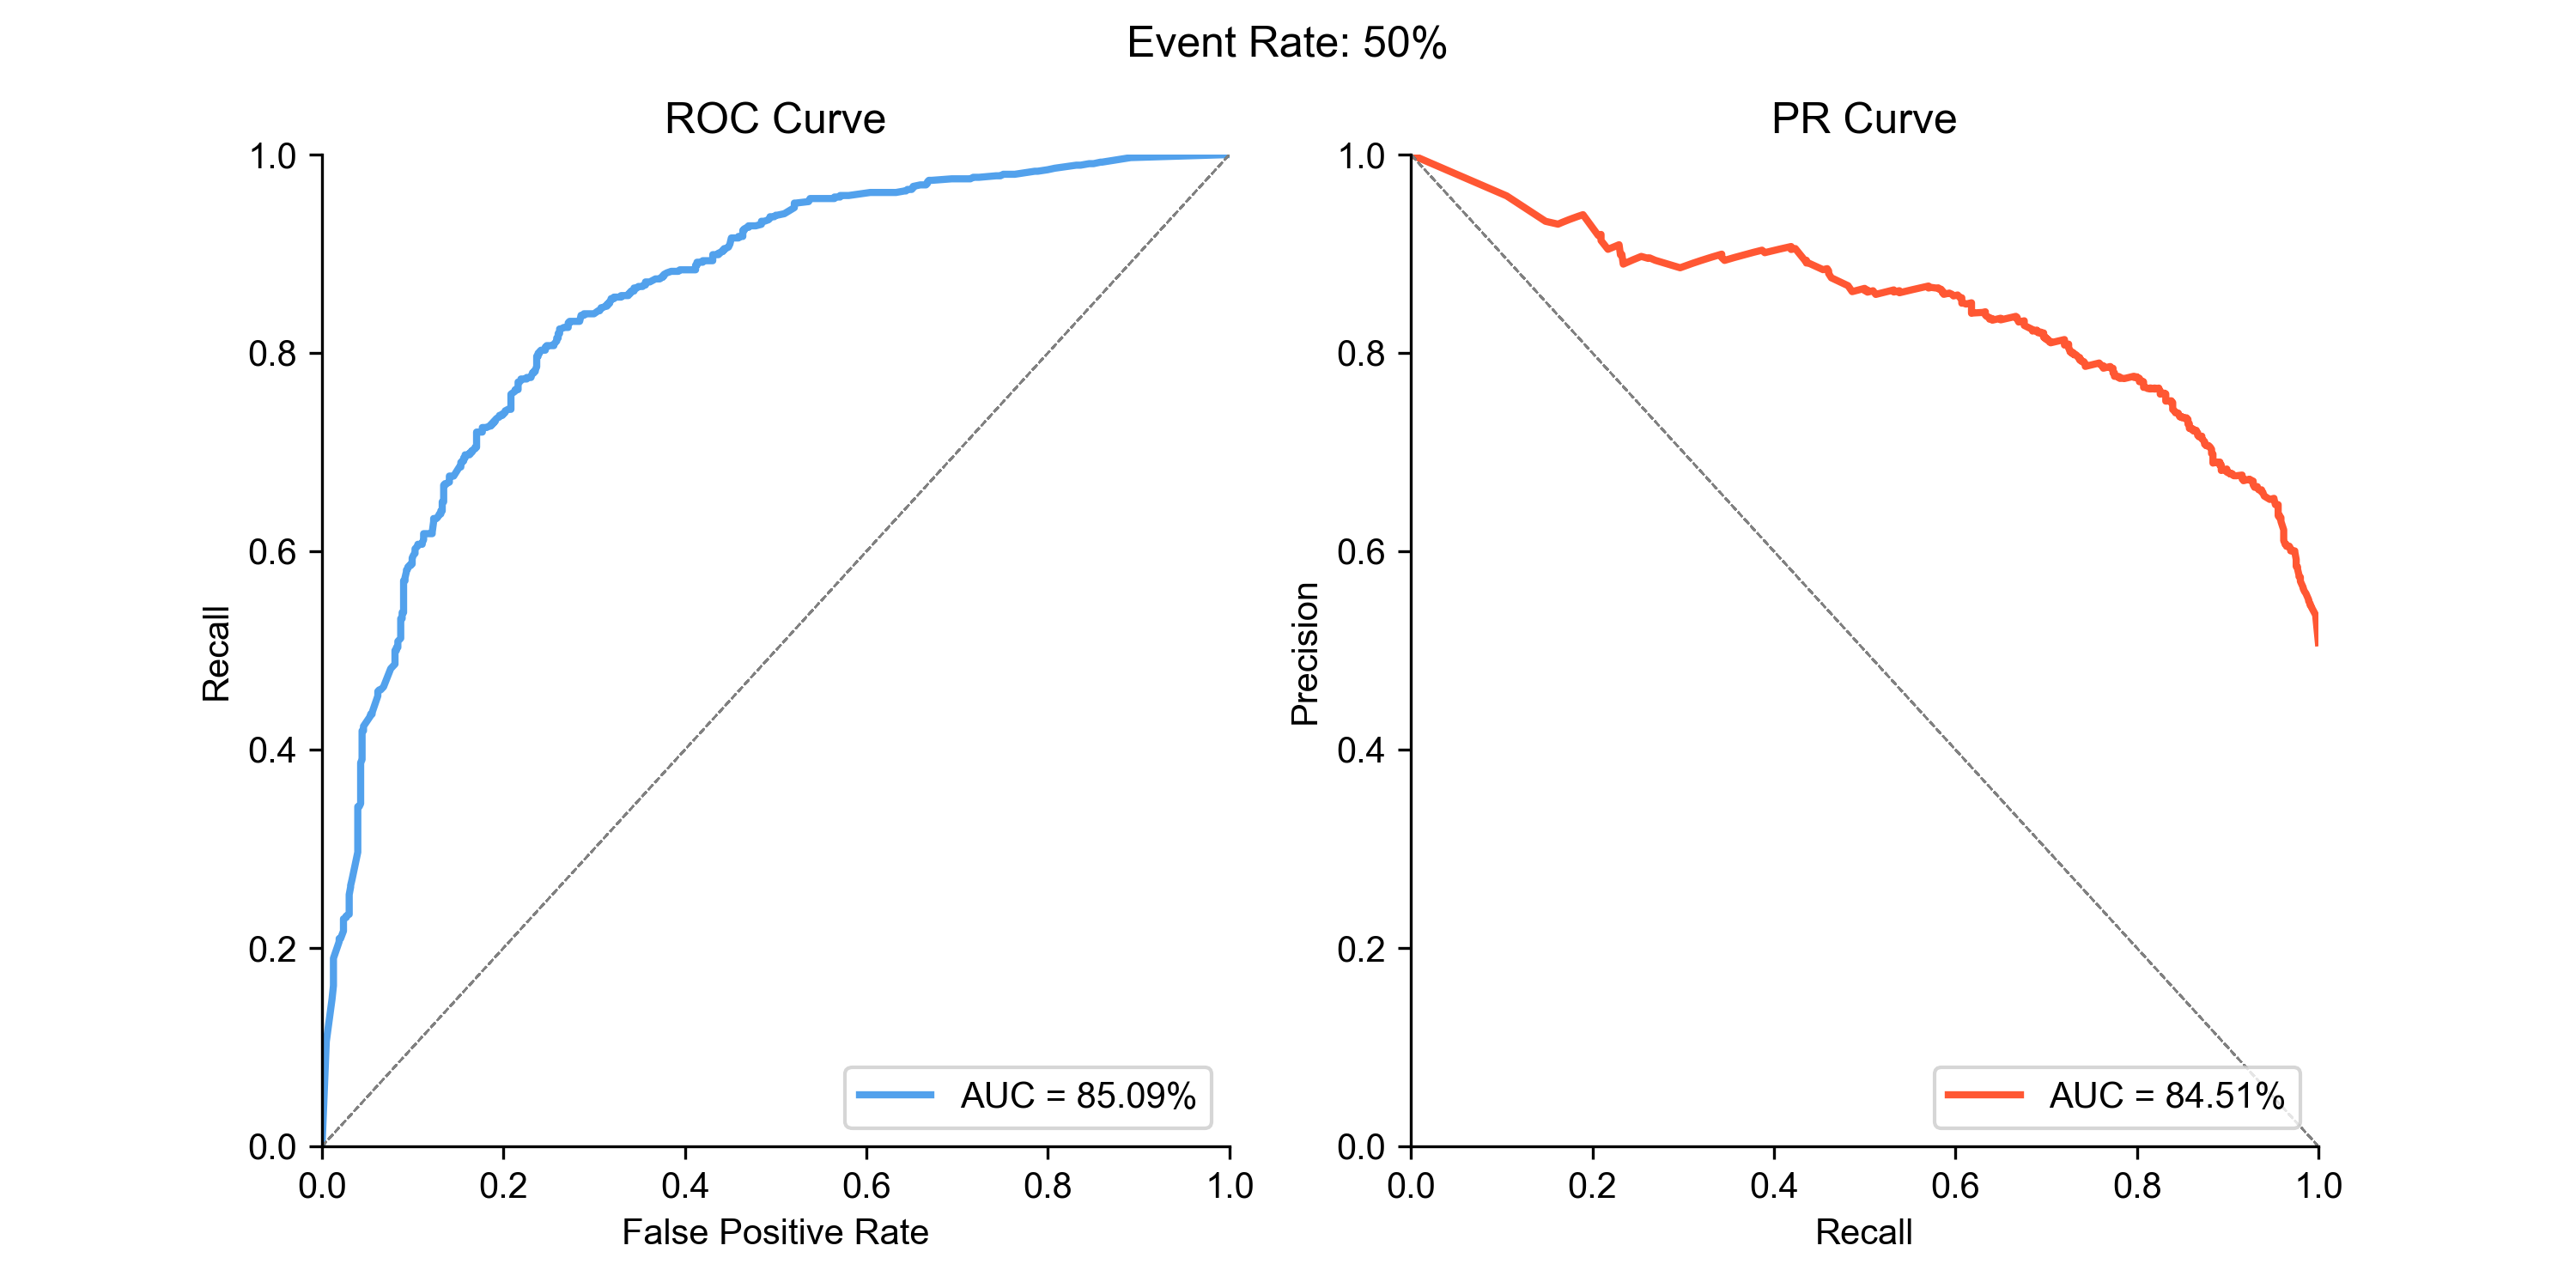

In [59]:
%matplotlib widget
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import numpy as np
import xgboost as xgb

# Create figure and subplots
fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
ax_roc.axis([0, 1, 0, 1])
ax_pr.axis([0, 1, 0, 1])
for ax in [ax_roc, ax_pr]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Initialize the ROC AUC plot and label
roc_plot, = ax_roc.plot([], [], lw=2, color="#52a1ec", label='ROC Curve')

# Initialize the PR AUC plot and label
pr_plot, = ax_pr.plot([], [], lw=2, color="#FF5733", label='PR Curve')

# Initialize classifiers dictionary
classifiers = {}

# Train classifiers for each sample
for sample_name in training_datasets["name"].unique():
    sample = training_datasets[training_datasets["name"] == sample_name]

    X_train = sample[features]
    y_train = sample[target]

    classifier = xgb.XGBClassifier(n_estimators=5, reg_lambda=8)
    classifier.fit(X_train, y_train)

    # Store the classifier in the dictionary
    classifiers[sample_name] = classifier
    
title_text = fig.suptitle("")

# Function to update both ROC and PR curves
def update_auc(i):
    sample_name = list(classifiers.keys())[i]
    classifier = classifiers[sample_name]

    X_test = training_datasets[training_datasets["name"] == sample_name][features]
    y_test = training_datasets[training_datasets["name"] == sample_name][target]

    # Get predicted probabilities
    y_scores = classifier.predict_proba(X_test)[:, 1]
    
    title_text.set_text(f"Event Rate: {sample_name}")

    # Update ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    roc_plot.set_data(fpr, tpr)
    roc_plot.set_label(f"AUC = {roc_auc:.2%}")
    ax_roc.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=0.5)
    ax_roc.set_title("ROC Curve")
    
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("Recall")

    # Update PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    pr_plot.set_data(recall, precision)
    pr_plot.set_label(f"AUC = {pr_auc:.2%}")
    ax_pr.plot([1, 0], [0, 1], color='gray', linestyle='--', linewidth=0.5)
    ax_pr.set_title("PR Curve")

    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    
    ax_roc.legend(loc='lower right')
    ax_pr.legend(loc='lower right')

    return roc_plot, pr_plot

# Create the animation
ani = FuncAnimation(fig, update_auc, frames=len(classifiers), repeat=True)
ani.save("auc_and_pr_xgb_.gif", writer="pillow", fps=3)

plt.show()

```python
import numpy as np
from matplotlib import pyplot as plt

y_true, y_scores = generate_synthetic_data(
        0.6,
        event_rate=0.1, 
        n_total=500
    )

def plot_cap(y, y_pred):
    n_samples = y.shape[0]
    n_event = np.sum(y)
    
    idx = y_pred.argsort()[::-1]
    yy = y[idx]
    
    p_event = np.append([0], np.cumsum(yy)) / n_event
    p_population = np.arange(0, n_samples + 1) / n_samples
    
    return p_event, p_population

n_event = np.sum(y_true)
n_samples = y_true.shape[0]
ideal_event_rate = n_event / n_samples

# Plotting CAP and the ideal line
p_event, p_population = plot_cap(y_true, y_scores)
plt.plot(p_population, p_event, label='CAP Curve', color='g')
plt.plot([0, 1], [0, 1], label='Random Curve', linestyle='--', color='gray')
plt.plot([0, ideal_event_rate, 1], [0, 1, 1], color="dodgerblue") # type: ignore

plt.xlabel('Cumulative share of observations')
plt.ylabel('Cumulative share of events')
plt.legend()
plt.show()
```

In [7]:
def AR_gini(target, prediction):

    ''' Calculate the gini coefficient, create and store the graph. 
    Target and prediction must be 
        numpy arrays or lists. '''
         
    # Step A. Create dataset and round prediction
    df = pd.DataFrame({'prediction': prediction, 'target': target})
    df['prediction'] = df['prediction'].round(10)

    # Throw an error if there are missing or infinite values
    assert df.isin([np.inf, -np.inf, np.nan]).values.sum() == 0, 'Illegal values found'

    # Step B. Create actual curve using sort by prediction
    df = df.sort_values(by=['prediction'], ascending=False)

    tp1 = df['target'].cumsum()
    tp1 = np.concatenate(([0], tp1)) / df['target'].sum()
    fp1 = np.linspace(0., 1., len(tp1))

    achievedY = (np.delete(tp1, np.where(df.duplicated(['prediction']))))
    achievedX = (np.delete(fp1, np.where(df.duplicated(['prediction']))))

    df2 = pd.DataFrame({'achievedX': achievedX, 'achievedY': achievedY})

    # Step C. Create predicted curve   
    df = df.sort_values(by=['target'], ascending=False)

    tp2 = df['target'].cumsum()
    perfectY = np.concatenate(([0], tp2)) / df['target'].sum()
    perfectX = np.linspace(0., 1., len(perfectY))

    df3 = pd.DataFrame({'perfectX': perfectX, 'perfectY': perfectY})

    # Step C. Create random curve
    df4 = pd.DataFrame({'randomX': [0, 1], 'randomY': [0, 1]})

    # Step D. Create lagged values
    df2['achievedY_lag'] = df2['achievedY'].shift(1).fillna(0)
    df2['achievedX_lag'] = df2['achievedX'].shift(1).fillna(0)
    df3['perfectX_lag'] = df3['perfectX'].shift(1).fillna(0)
    df3['perfectY_lag'] = df3['perfectY'].shift(1).fillna(0)

    # Step E. Calculate PowerStat
    PCF = sum(((df2['achievedY'] + df2['achievedY_lag']) / 2) * (df2['achievedX'] - df2['achievedX_lag']))
    OCF = sum(((df3['perfectY'] + df3['perfectY_lag']) / 2) * (df3['perfectX'] - df3['perfectX_lag']))

    return (PCF - 0.5) / (OCF - 0.5)

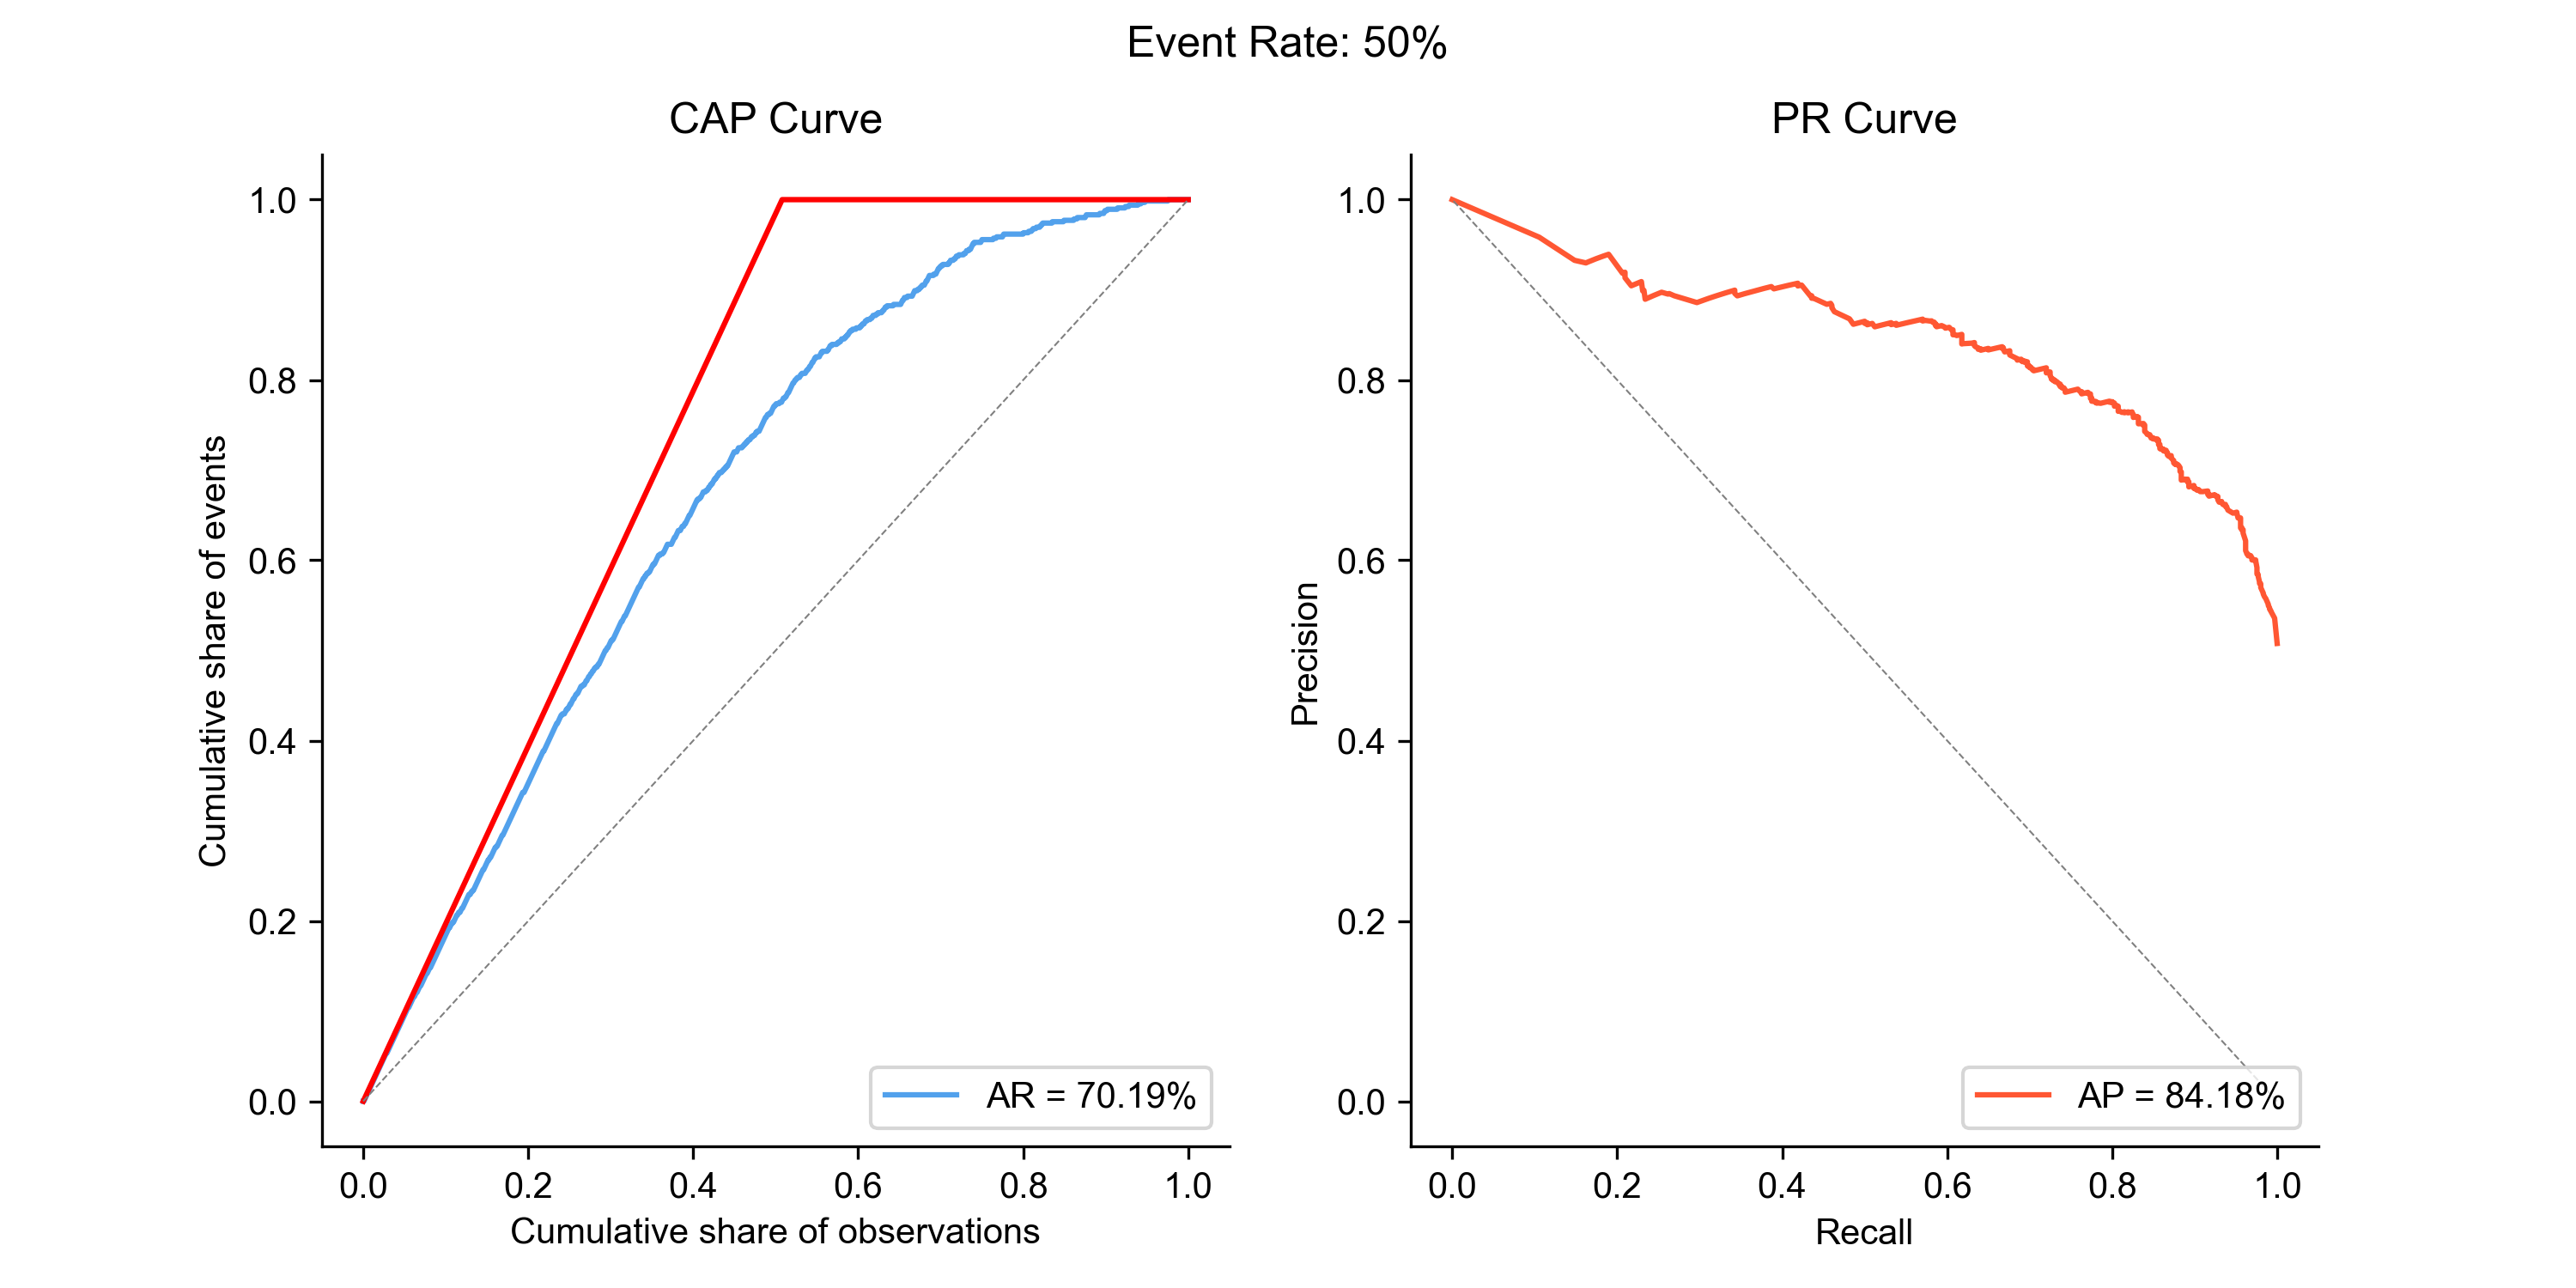

In [61]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.metrics import average_precision_score, precision_recall_curve, auc, roc_auc_score
import xgboost as xgb

def plot_cap(y, y_pred):
    
    y = y.values
    
    n_samples = y.shape[0]
    n_event = np.sum(y)
    idx = np.argsort(y_pred)[::-1]
    yy = y[idx]
    
    p_event = np.append([0], np.cumsum(yy)) / n_event
    p_population = np.arange(0, n_samples + 1) / n_samples
    
    # Data for the perfect model line
    ideal = [0, n_event / n_samples, 1], [0, 1, 1]
    
    # Data for the random model line
    random_model = [0, 1], [0, 1]
    
    accuracy_ratio = AR_gini(y, y_pred)
    
    return p_population, p_event, ideal, random_model, accuracy_ratio

# Create figure and subplots
fig, (ax_cap, ax_pr) = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
for ax in [ax_cap, ax_pr]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.axis([0, 1, 0, 1])

# Initialize classifiers dictionary
classifiers = {}

# Train classifiers for each sample
for sample_name in training_datasets["name"].unique():
    sample = training_datasets[training_datasets["name"] == sample_name]

    X_train = sample[features]
    y_train = sample[target]

    classifier = xgb.XGBClassifier(n_estimators=5, reg_lambda=8)
    classifier.fit(X_train, y_train)

    # Store the classifier in the dictionary
    classifiers[sample_name] = classifier

title_text = fig.suptitle("")

# Function to update both CAP and PR curves
def update_cap(i):  # sourcery skip: extract-duplicate-method
    sample_name = list(classifiers.keys())[i]
    classifier = classifiers[sample_name]

    X_test = training_datasets[training_datasets["name"] == sample_name][features]
    y_test = training_datasets[training_datasets["name"] == sample_name][target]

    # Get predicted probabilities
    y_scores = classifier.predict_proba(X_test)[:, 1]
    title_text.set_text(f"Event Rate: {sample_name}")

    # Get data for CAP curve
    p_population, p_event, ideal, random_model, accuracy_ratio = plot_cap(y_test, y_scores)
    
    # Update CAP curve
    ax_cap.clear()
    ax_cap.plot(p_population, p_event, color="#52a1ec", label=f'AR = {accuracy_ratio:.2%}')
    ax_cap.plot(ideal[0], ideal[1], color='red')
    ax_cap.plot(random_model[0], random_model[1], color='gray', linestyle='--', linewidth=0.5)
    ax_cap.set_xlabel('Cumulative share of observations') # type: ignore
    ax_cap.set_ylabel('Cumulative share of events')
    ax_cap.set_title('CAP Curve')

    # Update PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_ap = average_precision_score(y_test, y_scores)
    ax_pr.clear()
    ax_pr.plot(recall, precision, color="#FF5733", label=f'AP = {pr_ap:.2%}')
    ax_pr.plot([1, 0], [0, 1], color='gray', linestyle='--', linewidth=0.5)
    ax_pr.set_title("PR Curve")
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    
    ax_cap.legend(loc='lower right')
    ax_pr.legend(loc='lower right')

# # Create the animation
ani = FuncAnimation(fig, update_cap, frames=len(classifiers), repeat=True) # type: ignore
ani.save("cap_ap_xgb.gif", writer='pillow', fps=3)

plt.show()